In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import tensorflow as tf
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
from directories import TRAIN_DIR, VAL_DIR, TEST_DIR

In [7]:
# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2759 images belonging to 2 classes.
Found 920 images belonging to 2 classes.


In [8]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples/val_generator.batch_size
)

Epoch 1/40
86/86 [==============================] - 11s 98ms/step - loss: 0.6309 - accuracy: 0.6361 - val_loss: 0.5410 - val_accuracy: 0.7141
Epoch 2/40
86/86 [==============================] - 8s 95ms/step - loss: 0.5335 - accuracy: 0.7477 - val_loss: 0.4363 - val_accuracy: 0.7935
Epoch 3/40
86/86 [==============================] - 9s 99ms/step - loss: 0.4843 - accuracy: 0.7713 - val_loss: 0.3997 - val_accuracy: 0.8196
Epoch 4/40
86/86 [==============================] - 8s 98ms/step - loss: 0.4554 - accuracy: 0.7992 - val_loss: 0.4118 - val_accuracy: 0.8054
Epoch 5/40
86/86 [==============================] - 8s 98ms/step - loss: 0.4351 - accuracy: 0.8061 - val_loss: 0.3848 - val_accuracy: 0.8467
Epoch 6/40
86/86 [==============================] - 8s 97ms/step - loss: 0.4015 - accuracy: 0.8228 - val_loss: 0.3620 - val_accuracy: 0.8457
Epoch 7/40
86/86 [==============================] - 8s 98ms/step - loss: 0.4054 - accuracy: 0.8188 - val_loss: 0.3315 - val_accuracy: 0.8543
Epoch 8/40
8

In [12]:
# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
print("Test accuracy:", test_acc)

Found 921 images belonging to 2 classes.
28/28 [==============================] - 2s 62ms/step - loss: 0.1060 - accuracy: 0.9631
Test accuracy: 0.9630836248397827


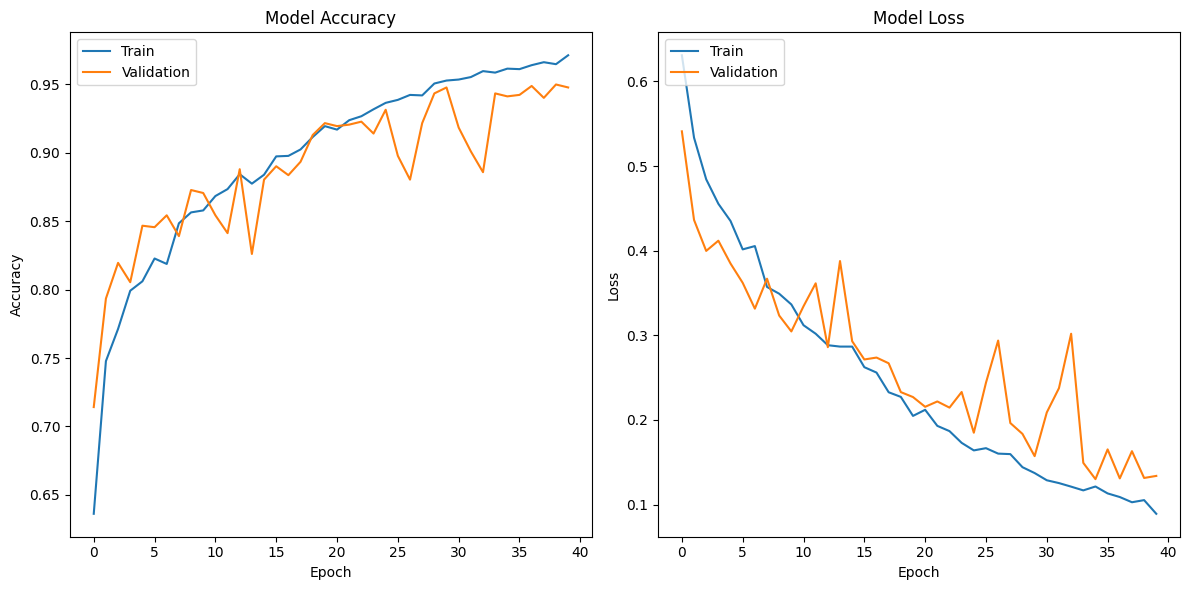

In [13]:
# Plot training & validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout() 
plt.show()


Found 921 images belonging to 2 classes.
29/29 [==============================] - 1s 36ms/step


<Figure size 800x600 with 0 Axes>

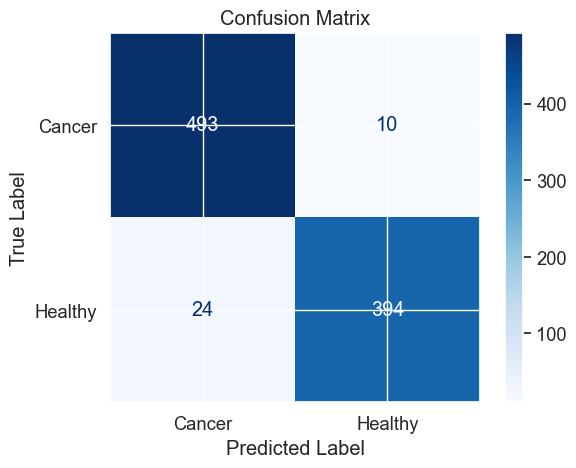

In [16]:
# Generate predictions for the test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False 
)

# Obtain model predictions
predictions = model.predict(test_generator).flatten() 

# Convert probabilities to binary predictions using a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set_theme(font_scale=1.2) 
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Healthy']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 [==============================] - 0s 176ms/step


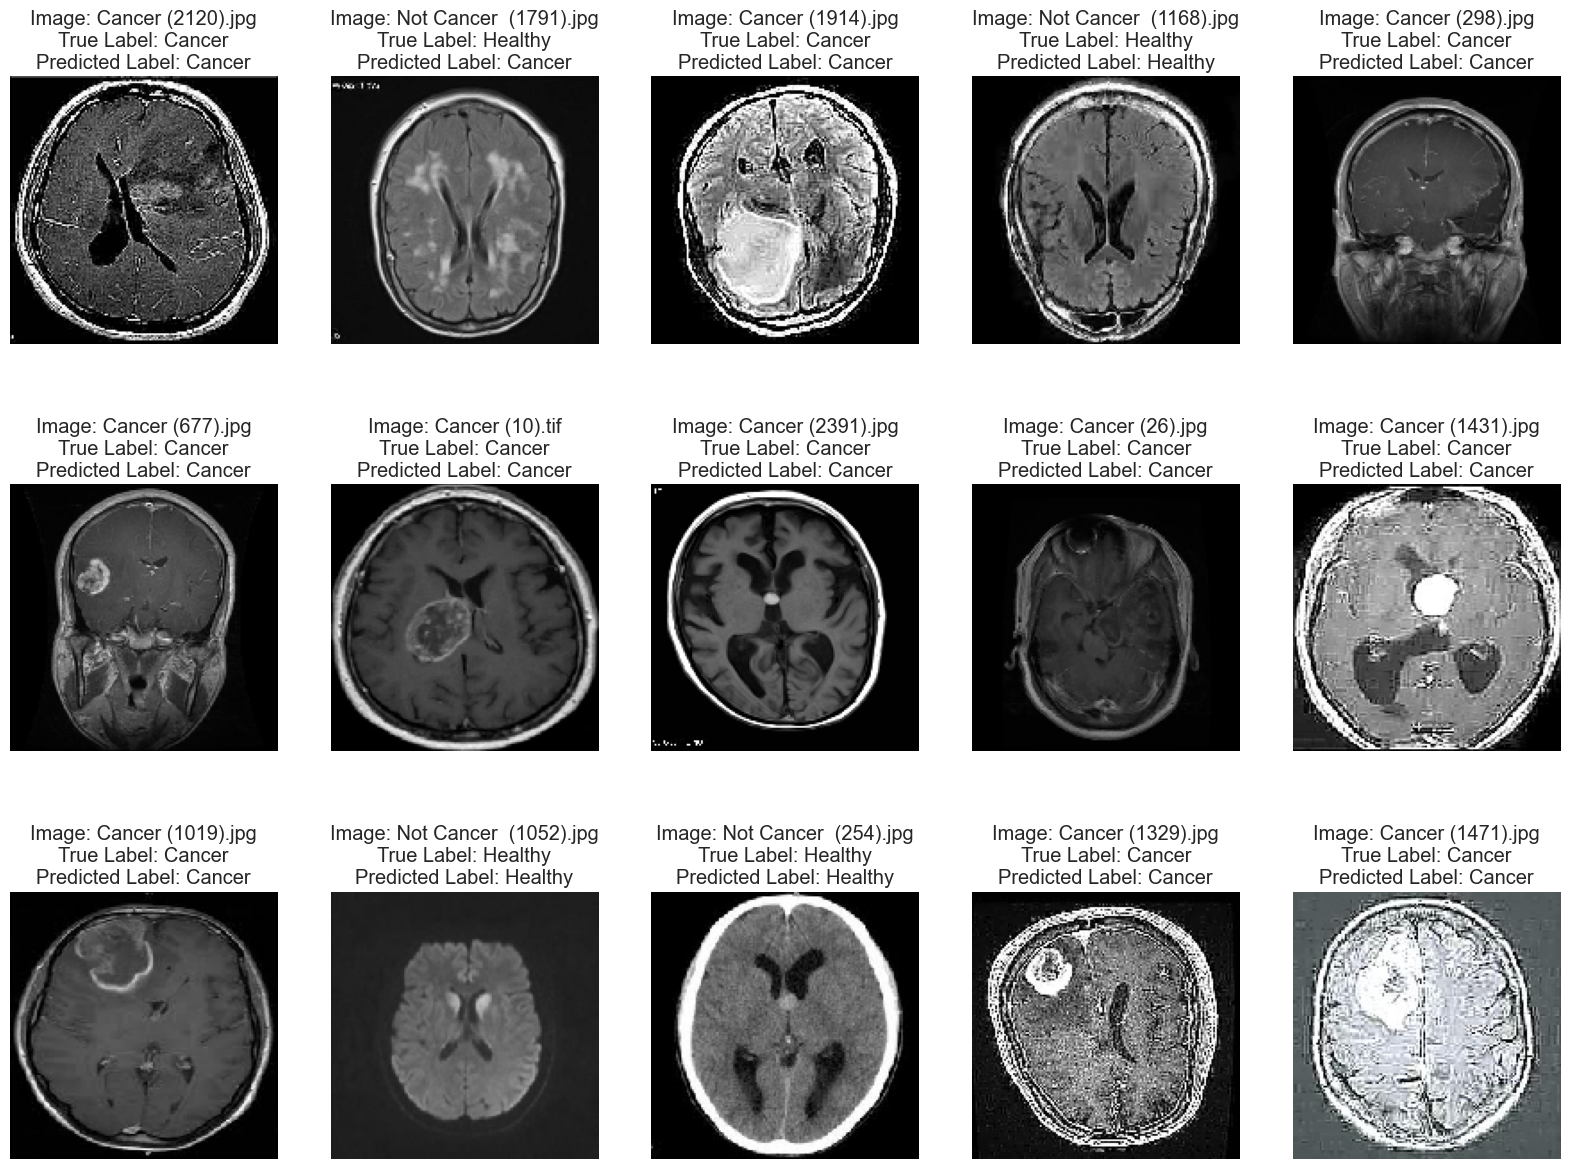

In [15]:
# Get 15 random test images
num_images = 15
random_indices = np.random.choice(len(test_generator.filenames), size=num_images, replace=False)
random_images = [test_generator.filepaths[i] for i in random_indices]

# Predict probabilities for random test images
probabilities = model.predict(np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=(150, 150))) for img in random_images]))

# Convert probabilities to predicted classes
predictions = (probabilities > 0.5).astype(int)

# Get true labels based on image file names
true_labels = []
for img_path in random_images:
    # Extract image name
    image_name = os.path.basename(img_path)
    # Extract label from image name
    if 'Not' in image_name:
        true_label = 'Healthy'
    else:
        true_label = 'Cancer'
    true_labels.append(true_label)

# Plot random test images with true labels and predictions
plt.figure(figsize=(20, 15))
for i, img_path in enumerate(random_images):
    plt.subplot(3, 5, i + 1)
    
    # Load and display image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    
    # Extract image name
    image_name = os.path.basename(img_path)
    
    # Get true label
    true_label = true_labels[i]
    
    # Get predicted label
    predicted_label = 'Cancer' if predictions[i] == 0 else 'Healthy'  # Interpret 0 as Cancer and 1 as Healthy
    
    # Display image name, true label, and predicted label
    plt.title(f"Image: {image_name}\nTrue Label: {true_label}\nPredicted Label: {predicted_label}")
    plt.axis('off')

plt.show()